In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, abspath
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from scipy import stats

In [3]:
import sys
sys.path.insert(0, abspath("../../"))

from utils_local import colors_v1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [8]:
# csv_path = "../../results/task_shift_ucf_090122.csv"
csv_path = "../../results/task_shift_150122.csv"

In [15]:
df = pd.read_csv(csv_path)

In [16]:
df

,Method,Action recognition (Top-1),Spatio-temporal (IoU@0.5),Repetition (MAE),AoT (Top-1)
0,No pretraining,75.36,0.3273,0.2320,56.106
1,RSPNET,86.31,0.4401,0.1600,86.955
2,Video Moco,85.59,0.4374,0.1759,72.905
3,Pretext-Contrast,85.83,0.4619,0.1685,77.227
4,Selavi,86.60,0.4192,0.1512,77.439
5,TCLR,89.77,0.4764,0.1493,85.633
6,CTP,90.77,0.4646,0.1783,77.055
7,GDT,91.14,0.4629,0.1367,76.368
8,AVID-CMA,89.33,0.4354,0.1619,83.254
9,Supervised pretraining,94.08,0.4825,0.1366,77.029


In [17]:
df.loc[9, "Method"] = "Supervised"

In [18]:
methods = df["Method"].values
tasks = set(df.columns) - {"Method"}

flat_df = []
for i, m in enumerate(methods):
    for t in tasks:
        flat_df.append([m, t, df.loc[i, t]])

flat_df = pd.DataFrame(flat_df, columns=["Method", "Task", "Metric"])

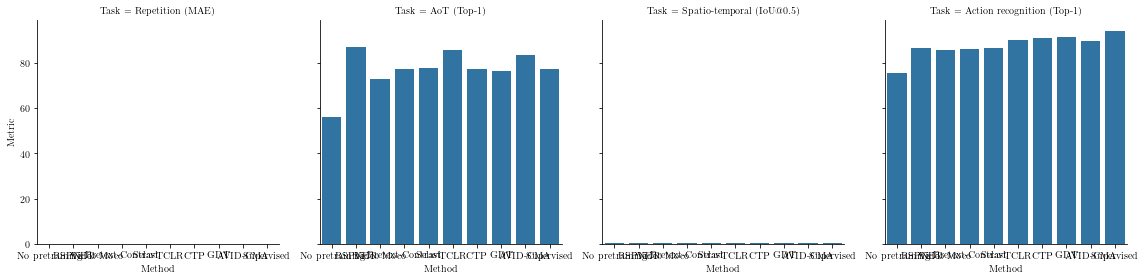

In [19]:
g = sns.FacetGrid(flat_df, col="Task", height=4)
g.map(sns.barplot, "Method", "Metric", order=methods)
plt.show()

In [20]:
rank_df = df.copy()
for t in tasks:
    if "MAE" not in t:
        rank_df[t] = df[t].argsort()
    else:
        rank_df[t] = (-1 * df[t]).argsort()

In [21]:
rank_corr = dict()

for t in tasks:
    rank_corr[f"AR-{t}"] = stats.spearmanr(rank_df["Action recognition (Top-1)"], rank_df[t]).correlation

In [22]:
rank_corr

{'AR-Repetition (MAE)': 0.4666666666666666,
 'AR-AoT (Top-1)': -0.10303030303030303,
 'AR-Spatio-temporal (IoU@0.5)': 0.5636363636363636,
 'AR-Action recognition (Top-1)': 0.9999999999999999}

In [23]:
tasks = ['Action recognition (Top-1)', 'Repetition (MAE)', 'Spatio-temporal (IoU@0.5)','AoT (Top-1)']

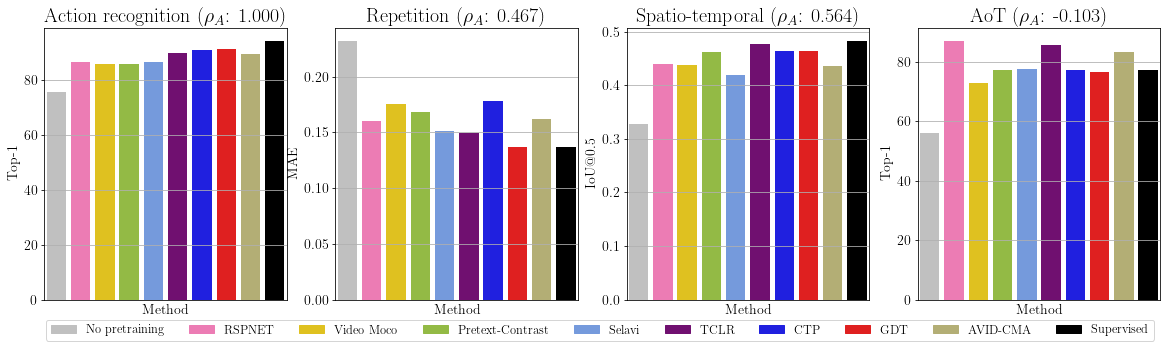

In [49]:
titlesize = 20
labelsize = 18

fig, axes = plt.subplots(1, len(tasks), figsize=(20, 5))

for i, t in enumerate(tasks):
    ax = axes[i]
    corr = rank_corr[f'AR-{t}']
    
    title, metric = t.split(" (")
    metric = metric.split(")")[0]
    ax.set_title(title + r" ($ \rho_{A} $" + f": {corr:.3f})", fontsize=titlesize)
    ax.grid()
    
    subdf = flat_df[flat_df["Task"] == t]
    label = None
    sns.barplot(data=subdf, x="Method", y="Metric", ax=ax, palette=colors_v1, label=label)
    
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=90, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    if i == len(tasks) - 1:
        labels = [x.get_text() for x in ax.get_xticklabels()]
        colors = [x.get_facecolor() for x in ax.get_children() if isinstance(x, plt.Rectangle)]
        patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
        ax.legend(handles=patches, ncol=len(patches), bbox_to_anchor=(1.0,-0.05), fontsize=12.5)

    # ax.legend(loc="upper right")
    ax.set_xticks([])
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.savefig("../../results/plots/task-shift-3.pdf", bbox_inches="tight")
plt.show()

## Junk

In [48]:
def heatmap(
        df,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        **kwargs,
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel("Dataset")
    ax.set_ylabel("Method")
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

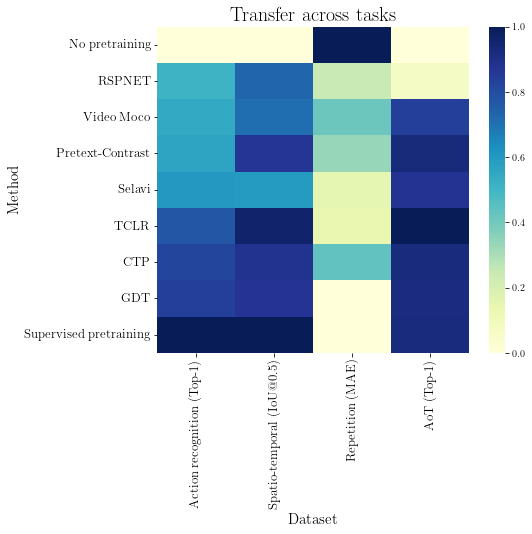

In [56]:
norm_df = df.set_index("Method")
norm_df = (norm_df - norm_df.min()) / (norm_df.max() - norm_df.min())

heatmap(norm_df, title="Transfer across tasks")

In [59]:
norm_df["Action recognition (Top-1)"].values

array([0.        , 0.50854701, 0.54647436, 0.55929487, 0.60042735,
       0.76976496, 0.82318376, 0.84294872, 1.        ])

In [61]:
norm_df["Spatio-temporal (IoU@0.5)"].values

array([0.        , 0.72680412, 0.70940722, 0.86726804, 0.59213918,
       0.96069588, 0.88466495, 0.87371134, 1.        ])

In [64]:
np.corrcoef(norm_df["Action recognition (Top-1)"].values, norm_df["Spatio-temporal (IoU@0.5)"].values)

array([[1.        , 0.92527473],
       [0.92527473, 1.        ]])

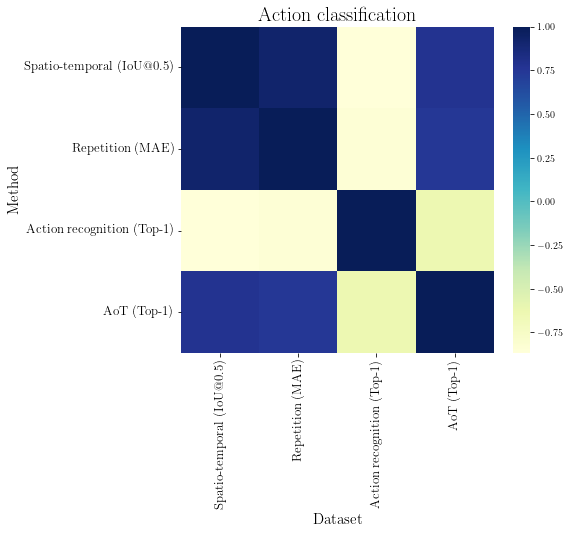

In [77]:
corr_df = pd.DataFrame(np.corrcoef(norm_df.T), index=tasks, columns=tasks)
heatmap(corr_df)

In [68]:
norm_df.shape

(9, 4)

In [76]:
corr_df

,Spatio-temporal (IoU@0.5),Repetition (MAE),Action recognition (Top-1),AoT (Top-1)
Spatio-temporal (IoU@0.5),1.000000,0.925275,-0.866820,0.775230
Repetition (MAE),0.925275,1.000000,-0.841615,0.746348
Action recognition (Top-1),-0.866820,-0.841615,1.000000,-0.634013
AoT (Top-1),0.775230,0.746348,-0.634013,1.000000


In [78]:
norm_df

,Action recognition (Top-1),Spatio-temporal (IoU@0.5),Repetition (MAE),AoT (Top-1)
Method,,,,
No pretraining,0.000000,0.000000,1.000000,0.000000
RSPNET,0.508547,0.726804,0.245283,0.069276
Video Moco,0.546474,0.709407,0.411950,0.841354
Pretext-Contrast,0.559295,0.867268,0.334382,0.929138
Selavi,0.600427,0.592139,0.153040,0.878900
TCLR,0.769765,0.960696,0.133124,1.000000
CTP,0.823184,0.884665,0.437107,0.924379
GDT,0.842949,0.873711,0.001048,0.915389
Supervised pretraining,1.000000,1.000000,0.000000,0.925436


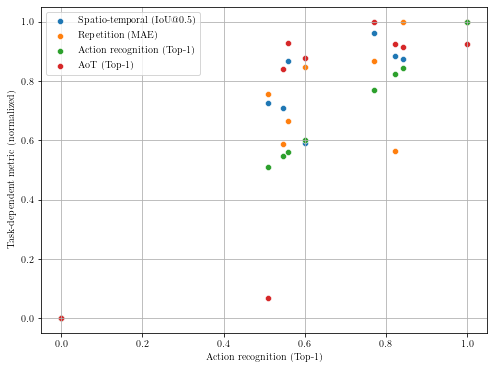

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
norm_df["Repetition (MAE)"] = 1 - norm_df["Repetition (MAE)"]

ax.grid()
for t in tasks:
    sns.scatterplot(x=norm_df["Action recognition (Top-1)"], y=norm_df[t], label=t, ax=ax)

ax.set_ylabel("Task-dependent metric (normalized)")
plt.show()